In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import sys
sys.path.append('..')
import code_package.tools_func as tool
import code_package.model_package as mcr2_model
DEVICE = 'cuda'
import seaborn as sns
import os

2025-07-08 04:01:47.454708: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-08 04:01:47.682423: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-08 04:01:47.682483: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-08 04:01:47.702937: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-08 04:01:47.768526: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import yaml
base_dir = './cmapss_mcr2_0621'

#configs = yaml.load(open('configs/cmapss_mcr2_config.yaml', 'r'), Loader=yaml.FullLoader)

In [4]:
params_path = os.path.join('model_params','cmapss_lrd.yaml')
cmapss_lrd_params = yaml.load(open(params_path, 'r'), Loader=yaml.FullLoader)
configs = yaml.load(open('configs/cmapss_mcr2_config.yaml', 'r'), Loader=yaml.FullLoader)

encoder_params = cmapss_lrd_params['encoder_params']
decoder_params = cmapss_lrd_params['decoder_params']

decoder_params['decoder_depth'] = 2
decoder_params['decoder_width'] = [200,50]
decoder_params['recons_activation'] = 'None'

encoder_params['encoder_activation'] = 'leaky_relu'
decoder_params['decoder_activation'] = 'leaky_relu'
encoder_params['cov_activation'] = 'None'
encoder_params['mu_activation'] = 'None'
DEVICE  = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

kl_weights = 1e-1#cmapss_lrd_params['kl_weights']
latent_dim = 3
datadir = os.path.join('dataloaders',str(latent_dim), 'cmapss_004.pt')
data_loader, data_set = torch.load(datadir, map_location=DEVICE)

class_dim = latent_dim
encoder_params['class_dim'] = class_dim
encoder_params['latent_dim'] = latent_dim
decoder_params['class_dim'] = class_dim
decoder_params['latent_dim'] = latent_dim
decoder_params['drop_rate'] = 0.1
lambdas = 1e-13
mcr2 =  mcr2_model.CVAE(encoder_params, decoder_params, is_ts=0, kl_weights=kl_weights)
mcr2.lambdas = lambdas
mcr2.to(DEVICE)
mcr2.device = DEVICE

/tmp/ipykernel_604041/1648783095.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_loader, data_set = torch.load(datadir, map_location=DEVICE)


In [7]:
import yaml
cmapss_cvae_params = {'encoder_params': encoder_params,
                      'decoder_params': decoder_params}

params_path = os.path.join('model_params','cmapss_ae.yaml')

with open(params_path, 'w') as file:
    yaml.dump(cmapss_lrd_params, file)

In [3]:
import os
import torch
import importlib
import data_pre
import sys
sys.path.append('..')
import warnings
warnings.filterwarnings("ignore")
import code_package.model_package as mcr2_model
import code_package.mcr2_trainer as mcr2_trainer
from code_package import run_code_timer
timer =  run_code_timer.Timer()

import yaml
params_path = os.path.join('model_params','cmapss_lrd.yaml')
cmapss_lrd_params = yaml.load(open(params_path, 'r'), Loader=yaml.FullLoader)
configs = yaml.load(open('configs/cmapss_cvae_config.yaml', 'r'), Loader=yaml.FullLoader)

encoder_params = cmapss_lrd_params['encoder_params']
decoder_params = cmapss_lrd_params['decoder_params']

decoder_params['decoder_depth'] = 2
decoder_params['decoder_width'] = [200,50]
decoder_params['recons_activation'] = 'None'

encoder_params['encoder_activation'] = 'leaky_relu'
decoder_params['decoder_activation'] = 'leaky_relu'
encoder_params['cov_activation'] = 'None'
encoder_params['mu_activation'] = 'None'

DEVICE  = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

for kl in [1e-3, 1e-2, 1e-1]:
    kl_weights = kl#cmapss_lrd_params['kl_weights']
    latent_dim = 3
    datadir = os.path.join('dataloaders',str(latent_dim), 'cmapss_004.pt')
    data_loader, data_set = torch.load(datadir, map_location=DEVICE)
    timer.start()
    class_dim = latent_dim
    encoder_params['class_dim'] = class_dim
    encoder_params['latent_dim'] = latent_dim
    decoder_params['class_dim'] = class_dim
    decoder_params['latent_dim'] = latent_dim
    decoder_params['drop_rate'] = 0.1
    lambdas = 1e-13
    mcr2 =  mcr2_model.CVAE(encoder_params, decoder_params, is_ts=0, kl_weights=kl_weights)
    mcr2.lambdas = lambdas
    mcr2.to(DEVICE)
    mcr2.device = DEVICE
    base_dir =os.path.join('./cmapss_cvae_0621/', 'kl_'+str(kl))
    configs['pre_train_epoch'] = 500
    configs['n_epoch'] = 600
    configs['save_freq'] = 150
    configs['kl_weights'] = kl_weights
    configs['pre_train_path'] = 'pre_train.pth'
    trainer  = mcr2_trainer.MCR2Trainer(mcr2, data_loader, data_set, configs, base_dir, DEVICE)
    best_overall_model_path,  val_loss_ls = trainer.multi_start_train(list(range(5)))
    torch.save(val_loss_ls, os.path.join(base_dir, 'val_loss_ls.pt'))
    timer.stop(is_print=True)

./cmapss_cvae_0621/kl_0.001/logs


100%|██████████| 600/600 [15:16<00:00,  1.53s/it]


Training complete. ./cmapss_cvae_0621/kl_0.001/models/0/best_model.pth


100%|██████████| 600/600 [15:12<00:00,  1.52s/it]


Training complete. ./cmapss_cvae_0621/kl_0.001/models/1/best_model.pth


100%|██████████| 600/600 [17:07<00:00,  1.71s/it]


Training complete. ./cmapss_cvae_0621/kl_0.001/models/2/best_model.pth


100%|██████████| 600/600 [14:44<00:00,  1.47s/it]


Training complete. ./cmapss_cvae_0621/kl_0.001/models/3/best_model.pth


100%|██████████| 600/600 [14:52<00:00,  1.49s/it]


Training complete. ./cmapss_cvae_0621/kl_0.001/models/4/best_model.pth
计时器已停止，总运行时间: 4634.02 秒。
./cmapss_cvae_0621/kl_0.01/logs


100%|██████████| 600/600 [13:53<00:00,  1.39s/it]


Training complete. ./cmapss_cvae_0621/kl_0.01/models/0/best_model.pth


100%|██████████| 600/600 [13:36<00:00,  1.36s/it]


Training complete. ./cmapss_cvae_0621/kl_0.01/models/1/best_model.pth


100%|██████████| 600/600 [13:20<00:00,  1.33s/it]


Training complete. ./cmapss_cvae_0621/kl_0.01/models/2/best_model.pth


100%|██████████| 600/600 [15:01<00:00,  1.50s/it]


Training complete. ./cmapss_cvae_0621/kl_0.01/models/3/best_model.pth


100%|██████████| 600/600 [14:56<00:00,  1.49s/it]


Training complete. ./cmapss_cvae_0621/kl_0.01/models/4/best_model.pth
计时器已停止，总运行时间: 4247.34 秒。
./cmapss_cvae_0621/kl_0.1/logs


100%|██████████| 600/600 [15:43<00:00,  1.57s/it]


Training complete. ./cmapss_cvae_0621/kl_0.1/models/0/best_model.pth


100%|██████████| 600/600 [17:04<00:00,  1.71s/it]


Training complete. ./cmapss_cvae_0621/kl_0.1/models/1/best_model.pth


100%|██████████| 600/600 [13:53<00:00,  1.39s/it]


Training complete. ./cmapss_cvae_0621/kl_0.1/models/2/best_model.pth


100%|██████████| 600/600 [13:43<00:00,  1.37s/it]


Training complete. ./cmapss_cvae_0621/kl_0.1/models/3/best_model.pth


100%|██████████| 600/600 [14:10<00:00,  1.42s/it]

Training complete. ./cmapss_cvae_0621/kl_0.1/models/4/best_model.pth
计时器已停止，总运行时间: 4476.16 秒。


In [14]:
model_path = os.path.join(base_dir, 'models')
ls = os.listdir(model_path)
ls.sort()
#print(ls)
best_start = '0' #ls[-1].split('_')[-1].split('.')[0]
best_start_model_path = os.path.join(model_path, best_start, 'best_model.pth')
mcr2.load_state_dict(torch.load(best_start_model_path, map_location=DEVICE)[0])
with torch.no_grad():
    res = mcr2(data_set['train'][0], data_set['train'][1], data_set['train'][2])
    loss_res = mcr2.loss_function(res, data_set['train'][0])

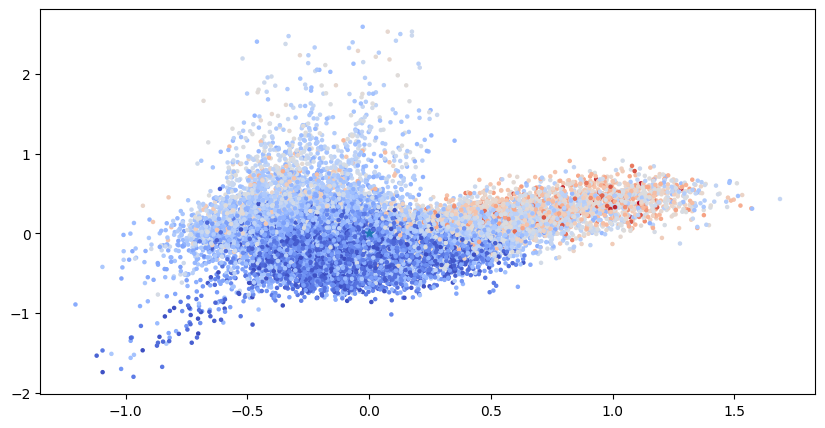

In [16]:
plt.figure(figsize=(10, 5))
idx = data_set['train'][4].cpu().numpy()[:,0] >1
plot_idx = [2,1]
#data_set['train'][4].cpu().numpy()[idx,1]
plt.scatter(res['z'][idx, plot_idx[0]].cpu().numpy(), res['z'][idx,plot_idx[1]].cpu().numpy(), c=data_set['train'][4].cpu().numpy()[idx,1], cmap='coolwarm', s=5)

#plt.scatter(res['direct'][idx, plot_idx[0]].cpu().numpy(), res['direct'][idx,plot_idx[1]].cpu().numpy(), c=res['z'][idx,plot_idx[1]].cpu().numpy(), cmap='coolwarm', s=5, alpha = 0.1)

plt.scatter(0,0,marker='*')


In [18]:
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=3, covariance_type='full')
gmm.fit(res['z'].cpu().numpy())

GaussianMixture(n_components=3)

In [19]:
labels = gmm.predict(res['z'].cpu().numpy())

<Axes: >

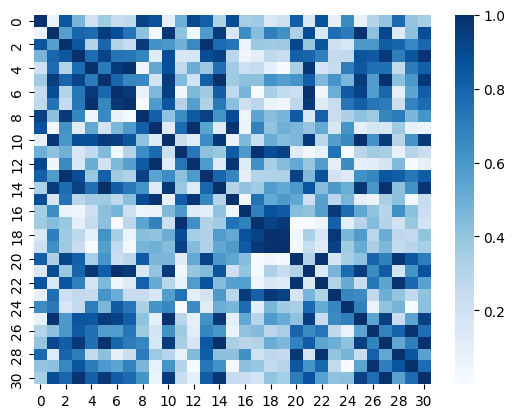

In [22]:
import seaborn as sns
pred_label = labels#= np.argmax(res['prob'].cpu(), axis=1)
z = res['z'][pred_label.argsort()]
z_norm = (z/torch.norm(z, dim=1, keepdim=True)).cpu().numpy()
heat_res = abs((z_norm @ z_norm.T)[::1000,::1000])
sns.heatmap(heat_res,cmap='Blues')


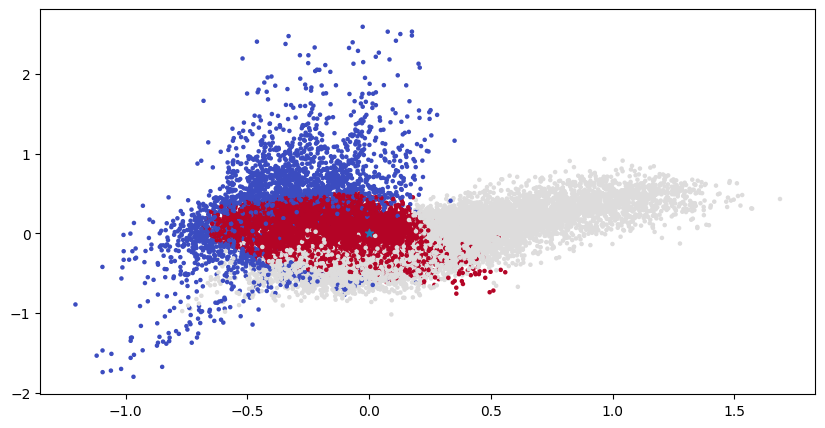

In [24]:
plt.figure(figsize=(10, 5))
idx = data_set['train'][4].cpu().numpy()[:,0] >=1
plot_idx = [2,1]
#data_set['train'][4].cpu().numpy()[idx,1]
plt.scatter(res['z'][idx, plot_idx[0]].cpu().numpy(), res['z'][idx,plot_idx[1]].cpu().numpy(), c=labels, cmap='coolwarm', s=5)

#plt.scatter(res['direct'][idx, plot_idx[0]].cpu().numpy(), res['direct'][idx,plot_idx[1]].cpu().numpy(), c=res['z'][idx,plot_idx[1]].cpu().numpy(), cmap='coolwarm', s=5, alpha = 0.1)

plt.scatter(0,0,marker='*')
